In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Bar
import folium
import h3
import matplotlib
from matplotlib.colors import Normalize
import plotly.graph_objs as go
import plotly.express as px

In [163]:
offer=pd.read_csv("datasets/data_offers.csv")
offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [165]:
order=pd.read_csv("datasets/data_orders.csv")
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [63]:
order.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [166]:
order['order_datetime']=pd.to_datetime(order['order_datetime'])
order['order_status_key']=order['order_status_key'].apply(lambda x:'Client Cancelled' if x==4 else 'System Cancelled')
order['is_driver_assigned_key']=order['is_driver_assigned_key'].apply(lambda x:'Yes' if x==1 else 'No')
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,2024-04-20 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0
1,2024-04-20 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0
2,2024-04-20 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0
3,2024-04-20 13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,Yes,62.0
4,2024-04-20 21:24:45,-0.967605,51.458236,NaN,3000583140877,System Cancelled,No,NaN


# (1)

In [167]:
cancellations = order.groupby(['is_driver_assigned_key','order_status_key']).size().reset_index(name='count')
cancellations

,is_driver_assigned_key,order_status_key,count
0,No,Client Cancelled,4496
1,No,System Cancelled,3406
2,Yes,Client Cancelled,2811
3,Yes,System Cancelled,3


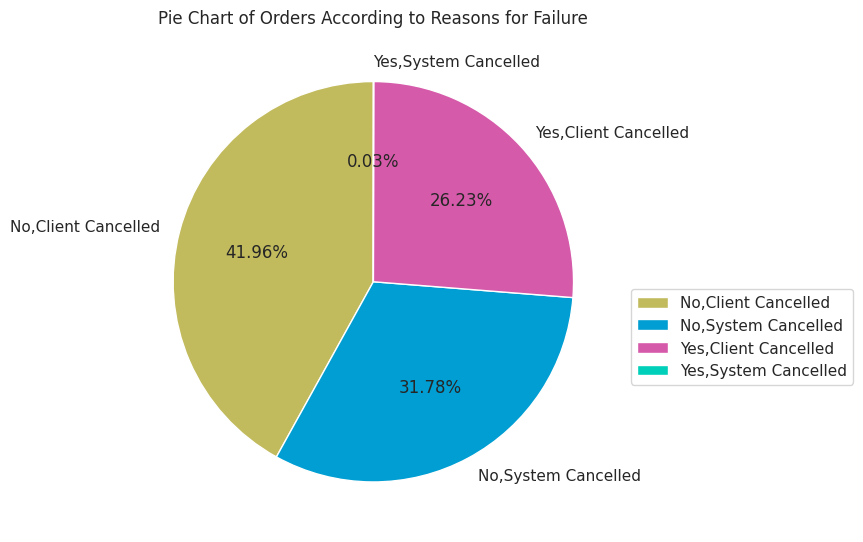

In [200]:
plt.figure(figsize=(6.5, 6.5))
labels = cancellations['is_driver_assigned_key'] + ',' + cancellations['order_status_key']
colors = ['#C2BB5E', '#009ED2', '#D65AAA', '#00CFB9']
plt.pie(cancellations['count'], labels=labels, colors=colors, autopct='%.2f%%', startangle=90)
plt.title('Pie Chart of Orders According to Reasons for Failure')
plt.legend(labels=labels, loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

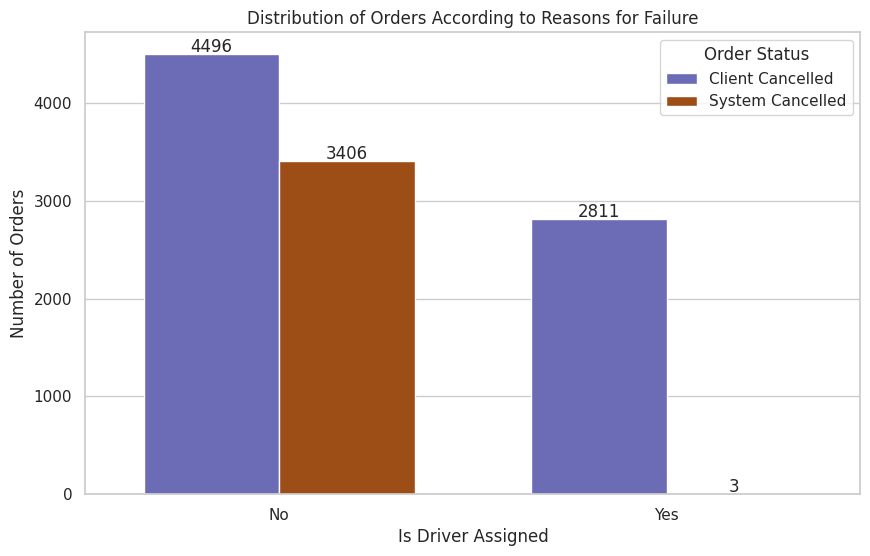

In [176]:
colors = {'Client Cancelled': '#605EC2', 'System Cancelled': '#B34A00'}
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=cancellations, x='is_driver_assigned_key', y='count', hue='order_status_key', palette=colors,width=0.7)
ax.legend(title='Order Status')
for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
plt.title('Distribution of Orders According to Reasons for Failure')
plt.xlabel('Is Driver Assigned')
plt.ylabel('Number of Orders')
plt.show()

A significant number of clients canceled their orders before a driver was assigned, indicating
that they may wait a long time for driver assignment. Before driver assignment, the highest
number among all categories, 4496, were client rejections, while 3406 were system rejections. After
the driver was assigned, 2811 cancellations were made by clients and 3 were made by system.

# (2)

In [196]:
order["order_hour"] = order['order_datetime'].dt.hour
group_hour=order.groupby(['order_hour','is_driver_assigned_key','order_status_key']).size().reset_index(name="count")
group_hour

,order_hour,is_driver_assigned_key,order_status_key,count
0,0,No,Client Cancelled,298
1,0,No,System Cancelled,263
2,0,Yes,Client Cancelled,120
3,0,Yes,System Cancelled,2
4,1,No,Client Cancelled,219
...,...,...,...,...
69,22,No,System Cancelled,241
70,22,Yes,Client Cancelled,149
71,23,No,Client Cancelled,378
72,23,No,System Cancelled,302


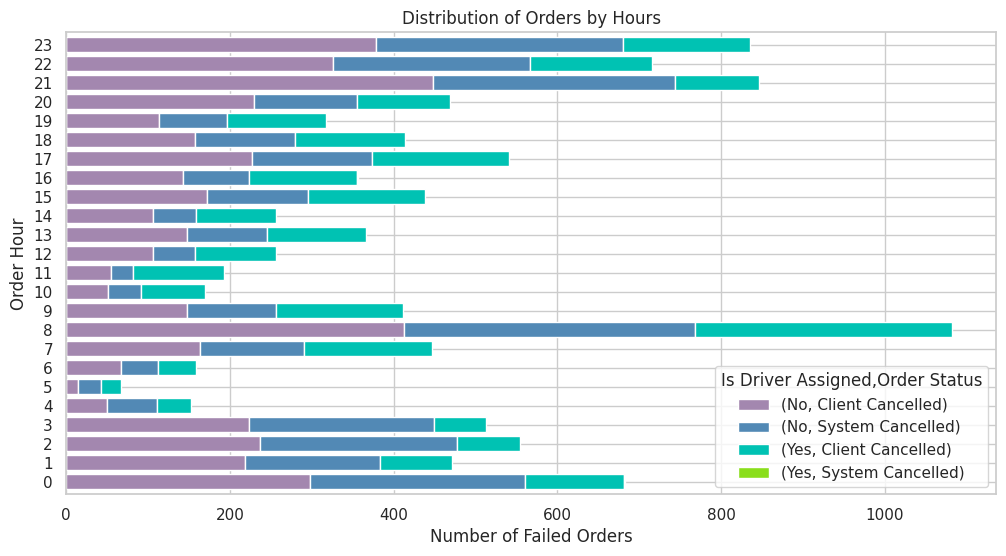

In [224]:
colors=['#A387AF','#5289B5','#00C2B3','#8ADE1B']
table = group_hour.pivot(index='order_hour',columns=['is_driver_assigned_key','order_status_key'], values='count')
table.plot(kind='barh', color=colors,stacked=True, figsize=(12, 6),width=0.8)
plt.ylabel('Order Hour')
plt.xticks(rotation=0)
plt.xlabel('Number of Failed Orders')
plt.title('Distribution of Orders by Hours')
plt.legend(title="Is Driver Assigned,Order Status")
plt.show()

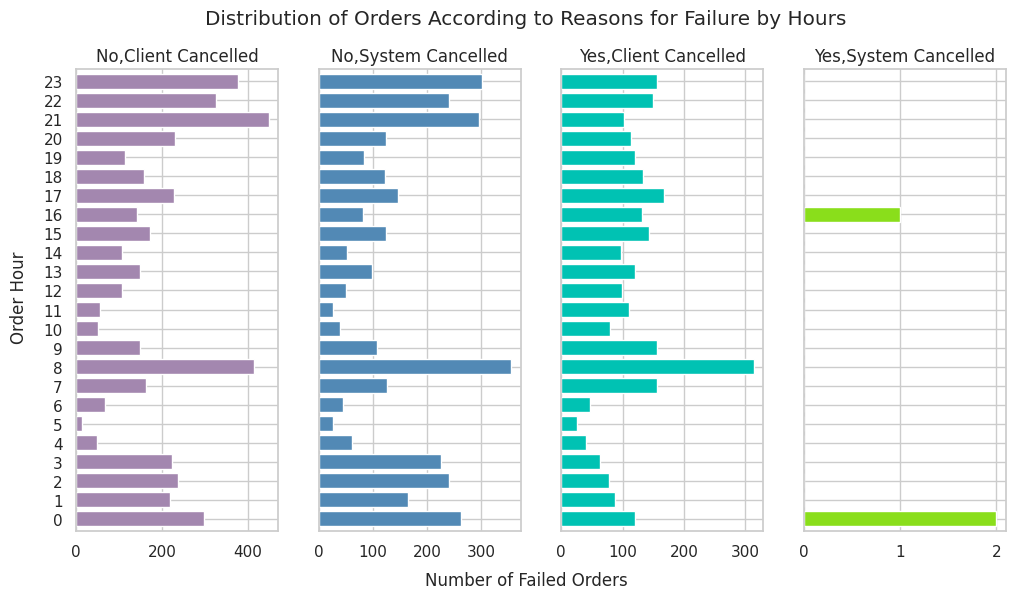

In [240]:
table = group_hour.pivot(index='order_hour', columns=['is_driver_assigned_key', 'order_status_key'], values='count')
fig, axs = plt.subplots(1,4, figsize=(12, 6), sharey=True)

for i, (column, ax) in enumerate(zip(table.columns, axs)):
    table[column].plot(kind='barh', stacked=False, color=colors[i], ax=ax, width=0.8)
    ax.set_ylabel('')
    ax.set_title(labels[i])
fig.text(0.5, 0.02, 'Number of Failed Orders', ha='center')
fig.text(0.07, 0.5, 'Order Hour', va='center', rotation='vertical')
fig.suptitle('Distribution of Orders According to Reasons for Failure by Hours')
plt.show()

The highest number of failed orders occurred at hour 8, followed by hours 21 and 23. The
highest number of orders canceled by clients before driver assignment occurred at hour 21, while
orders canceled by system after driver assignment occurred at hour 0. The remaining categories
predominantly occurred at hour 8. At hour 8, 17 and 18, the 3 categories have abnormally close
proportions. During commuting hours like these, high demand for transportation causes all reasons
for order cancellations. This can lead to a high number of cancellations and remarkably similar
proportions among the three categories of cancellations. During the timeframe from 9 PM to 3 AM
the following day, there is a decrease in the number of available drivers, leading to longer waiting
times, which may cause a higher volume of order cancellations as well.
3.The average time to cancellation is higher on with driver assigned than those without driver
assigned for each hour. After drivers are assigned, cancellations may take longer to occur due to
various reasons such as passengers changing their plans or drivers arriving late. The peak occurred
at Hour 2 and followed by hour 0, 3 and 23. During these nighttime hours, when there are fewer
available drivers and transportation becomes less convenient, people often experience longer waiting
times before cancellation. A small sample size such as at hour 5 may also affect the distribution of
average cancellation times.


## (3)

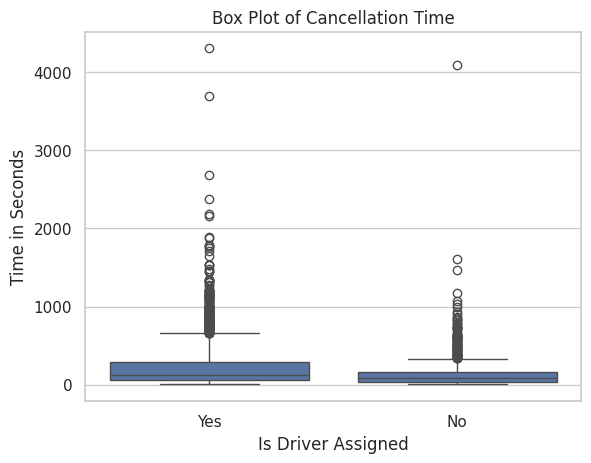

In [161]:
#drop the rows whose cancellation time is null
clean_order=order.dropna(subset=['cancellations_time_in_seconds'])
#use box plot to find outliers
sns.boxplot(x='is_driver_assigned_key',y='cancellations_time_in_seconds',data=clean_order)
plt.title('Box Plot of Cancellation Time')
plt.ylabel('Time in Seconds')
plt.xlabel('Is Driver Assigned')
plt.show()

In [251]:
#remove points whose cancellation time is larger than 2000s if driver is assigned
#if driver is not assigned, remove points whose cancellation time is larger than 1500s
clean_order = clean_order.loc[((clean_order['cancellations_time_in_seconds'] <= 2000) & (clean_order['is_driver_assigned_key'] == 'Yes')) | ((clean_order['cancellations_time_in_seconds'] <= 1500) & (clean_order['is_driver_assigned_key'] == 'No'))]
time_order=clean_order.groupby(['order_hour','is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index(name='Average Cancellation Time')                                                                                                                                 

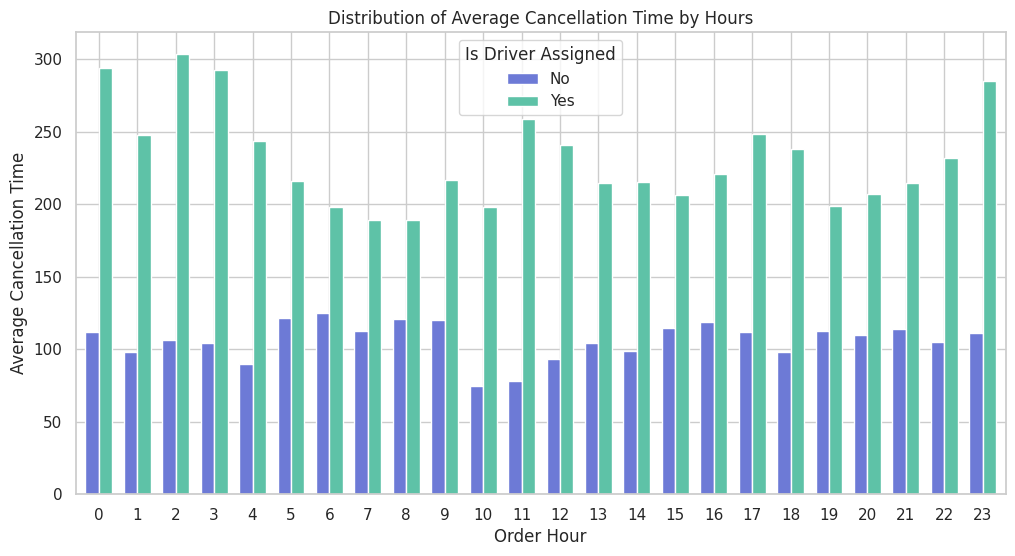

In [252]:
table =time_order.pivot(index='order_hour',columns=['is_driver_assigned_key'], values='Average Cancellation Time')
table.plot(kind='bar', stacked=False, figsize=(12, 6),color=['#6D7AD6','#5EC2A7'],width=0.7)
plt.xlabel('Order Hour')
plt.xticks(rotation=0)
plt.ylabel('Average Cancellation Time')
plt.title('Distribution of Average Cancellation Time by Hours')
plt.legend(title="Is Driver Assigned")
plt.show()

The average time to cancellation is higher on with driver assigned than those without driver
assigned for each hour. After drivers are assigned, cancellations may take longer to occur due to
various reasons such as passengers changing their plans or drivers arriving late. The peak occurred
at Hour 2 and followed by hour 0, 3 and 23. During these nighttime hours, when there are fewer
available drivers and transportation becomes less convenient, people often experience longer waiting
times before cancellation. A small sample size such as at hour 5 may also affect the distribution of
average cancellation times.
1


## (4)

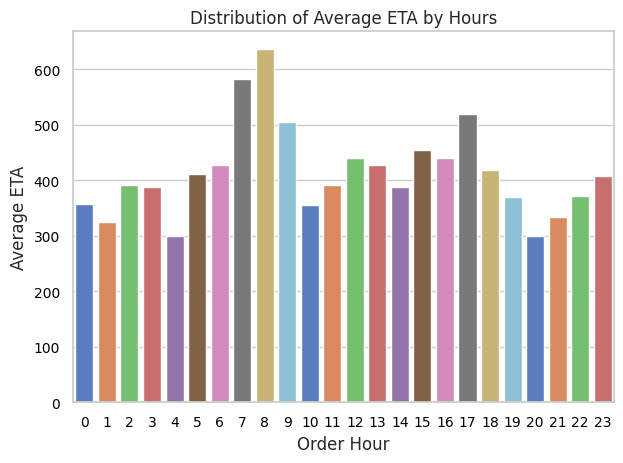

In [253]:
#drop the rows whose ETA is null
clean_order2=order.dropna(subset=['m_order_eta'])
time_order2=clean_order2.groupby(['order_hour'])['m_order_eta'].mean().reset_index(name='Average ETA')
sns.set(style="whitegrid")

sns.barplot(x=time_order2["order_hour"], y=time_order2["Average ETA"], hue=time_order2["order_hour"],palette="muted",legend=False)
plt.title('Distribution of Average ETA by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Average ETA')
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.tight_layout()
plt.show()

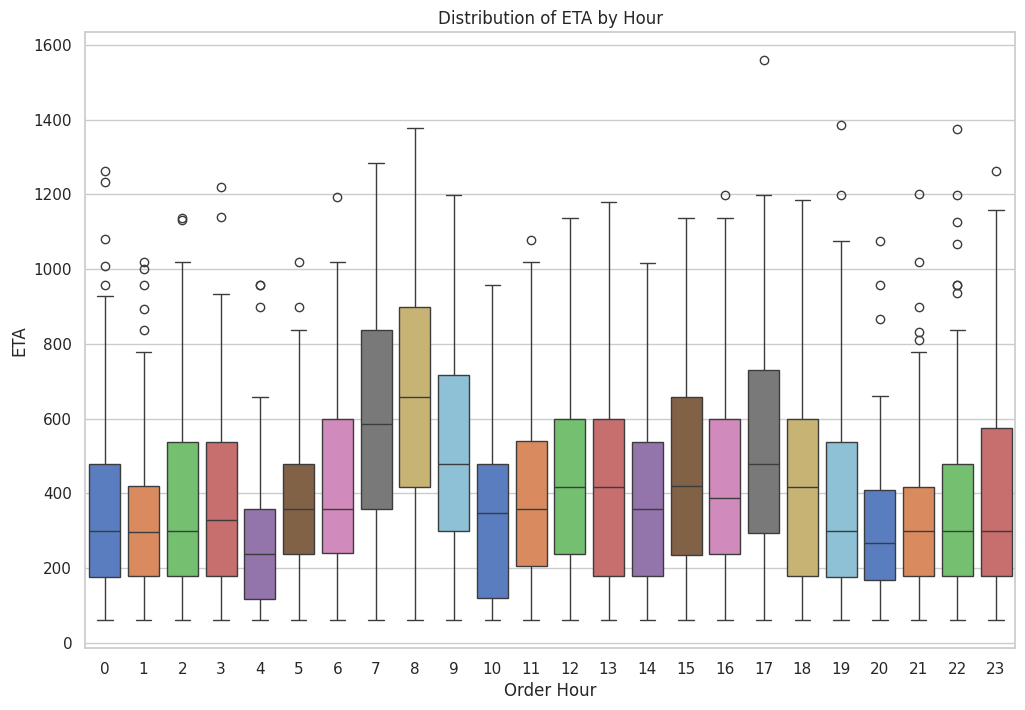

In [255]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=clean_order2, x="order_hour", y="m_order_eta",hue="order_hour",palette="muted",legend=False)
plt.title('Distribution of Average ETA by Hours')
plt.xlabel('Order Hour')
plt.ylabel('ETA')
plt.title('Distribution of ETA by Hour')
plt.show()

The close match between the distribution of ETA and the number of failed orders per hour
suggests that a longer waiting time can contribute to higher rates of order failures. During com-
muting hours at 7, 8, and 17, the high volume of traffic can result in increased ETA.

## (5)

In [15]:
# H3 index for each order location
order['h3_index'] = order.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

In [16]:
# number of orders in each hexagon
hex_count = order['h3_index'].value_counts().reset_index(name='count')
# Sort hexagons
hex_count = hex_count.sort_values(by='count', ascending=False)
# cumulative sum of counts
hex_count['cum_count'] = hex_count['count'].cumsum()
hex_count

,index,count,cum_count
0,88195d2b1dfffff,1497,1497
1,88195d2b1bfffff,870,2367
2,88195d2b15fffff,774,3141
3,88195d2b11fffff,707,3848
4,88195d2b19fffff,667,4515
...,...,...,...
139,88195d2821fffff,1,10712
140,88195d3993fffff,1,10713
141,88195d2b69fffff,1,10714
142,88195d74d5fffff,1,10715


In [17]:
# Find the first index where cumulative sum > 80% of total
index = hex_count[hex_count['cum_count'] > 0.8 * len(order)].index[0]
hex_df=hex_count.iloc[:index+1]
print("Number of Hexes:",hex_df.shape[0])
m = folium.Map(location=[order['origin_latitude'].mean(), order['origin_longitude'].mean()], zoom_start=10)

#colour the hexes by the number of fails
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(x * 255) for x in rgb[:3])
norm = Normalize(vmin=0, vmax=hex_df['count'].max())
cmap = matplotlib.colormaps['plasma']    

for index, row in hex_df.iterrows():
    polygon = h3.h3_to_geo_boundary(row['index'])
    color = cmap(norm(row['count']))  
    folium.Polygon(
    locations=polygon, 
    fill=True,  
    color=rgb_to_hex(color), 
    fill_opacity=0.5,  
    popup=f"Failed Order Count: {row['count']}"  
).add_to(m)

m.save('map.html')

Number of Hexes: 24


24 sizes 8 hexes contain 80% of all orders from the original data sets.